In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
prefs.codegen.target = 'cython'

In [3]:
LIF_eqn = '''
dv/dt = ((v0 - v) + R_m * (I_exc - I_inh)) / tau_m : volt (unless refractory)
dI_exc/dt = -I_exc / tau_exc : ampere
dI_inh/dt = -I_inh / tau_inh : ampere
'''

Pred_eqn = '''
dv/dt = ((v0 - v) + R_m * w_pred*Pred(t-delay_Pred)) / tau_m : volt (unless refractory)
w_pred : 1
'''

Stim_eqn = '''
dv/dt = ((v0 - v) + R_m * Stim(t-delay_Stim, i)) / tau_m : volt (unless refractory)
'''

R_m = 1*Mohm
C_m = 30*nF
tau_m = C_m*R_m
print(f'tau_m = {tau_m}')

v0 = 0*mV
v_th = 10*mV
tau_ref = 2*ms

tau_exc = 5*ms
tau_inh = 20*ms

w_S_IN = 0.5
w_S_PEP = 0.5
w_P_IP = 0.5
w_P_PEN = 0.5
w_IP_PEP = 0.2
w_IN_PEN = 0.2

w_factor = 1*uA

delay_S_IN = 10*ms
delay_S_PEP = 20*ms
delay_P_IP = 10*ms
delay_P_PEN = 20*ms
delay_IP_PEP = 5*ms
delay_IN_PEN = 5*ms

delay_Pred = 5*ms
delay_Stim = 5*ms

pred_learning_rate_PEP = 0.001
pred_learning_rate_PEN = pred_learning_rate_PEP * 0.3

# w_lateral_max = 1
# Apre = 0.01
# Apost = 0.01
# taupre = 20*ms
# taupost = 20*ms

lateral_weight_scale = 1.2
lateral_delay_scale = 5*ms

tau_m = 30. ms


In [4]:
N_streams = 5
stim_timing = [2, 13]  # [0]*stim_dt on, [1]*stim_dt off
stim_dt = 10*ms
input_strength = 0.2*w_factor
stim_kernel = [1, 0.2]

In [5]:
def get_oddball_seq(occurrences):
    #                     n occurrences of i
    seq = np.concatenate([np.ones(n, int)*i for i, n in enumerate(occurrences)])
    np.random.shuffle(seq)  # seq now describes the oddball sequence (e.g. with A=0, B=1, O=2)
    return seq

def get_stream_kernels(stream_indices, kernel, N_streams):
    '''
    Fills a size (len(stream_indices)+1, N_streams) array with input kernel values. The final row is left empty (zeros) to represent omissions.
    Args:
        stream_indices: List of receptive field centers (0, ..., N_streams-1). Order as in @fn:get_oddball_seq's `occurrences` parameter.
            E.g., if occurrences are [10, 4, 2] for [A, B, O], and A is stream #1 and B is stream #3, then stream_indices should be [1, 3].
        kernel: List of input values, starting from the stream center.
        N_streams: Number of streams.
    Example:
        > get_stream_kernels([1,3], [1,0.5], 5)
        < array([[0.5, 1. , 0.5, 0. , 0. ],
                 [0. , 0. , 0.5, 1. , 0.5],
                 [0. , 0. , 0. , 0. , 0. ]])
    '''
    kernels = np.zeros((len(stream_indices) + 1, N_streams))
    for i, idx in enumerate(stream_indices):
        for j, k in enumerate(kernel):
            for sign in (+1, -1):
                try:
                    kernels[i, idx + sign*j] = k
                except IndexError:
                    pass
    return kernels

def get_oddball_inputs(occurrences, stream_indices, kernel=stim_kernel, N_streams=N_streams, timing=stim_timing):
    seq = get_oddball_seq(occurrences)
    kernels = get_stream_kernels(stream_indices, kernel, N_streams)
    array = []
    for stream in seq:
        for _ in range(timing[0]):  # Stimulus on, apply stim kernel
            array.append(kernels[stream])
        for _ in range(timing[1]):  # Stimulus off, apply omission kernel (= zeros)
            array.append(kernels[-1])
    return seq, np.stack(array)

In [6]:
Net = Network()

In [7]:
def make_neurons(Net):
    circuit_neurons = NeuronGroup(4*N_streams, LIF_eqn, threshold='v > v_th', reset='v = v0', refractory=tau_ref, name='circuit', method='exact')
    Net.add(circuit_neurons)

    PEP = circuit_neurons[:N_streams]
    PEN = circuit_neurons[N_streams:2*N_streams]
    IP = circuit_neurons[2*N_streams:3*N_streams]
    IN = circuit_neurons[3*N_streams:]

    P = NeuronGroup(N_streams, Pred_eqn, threshold='v > v_th', reset='v = v0', refractory=tau_ref, name='P', method='euler')
    P.w_pred = 0
    Net.add(P)

    S = NeuronGroup(N_streams, Stim_eqn, threshold='v > v_th', reset='v = v0', refractory=tau_ref, name='S', method='euler')
    Net.add(S)

    states = {
        'P': StateMonitor(P, ['v', 'w_pred'], record=True),
        'S': StateMonitor(S, ['v'], record=True),
        'PEP': StateMonitor(PEP, ['v'], record=True),
        'PEN': StateMonitor(PEN, ['v'], record=True),
        'IP': StateMonitor(IP, ['v'], record=True),
        'IN': StateMonitor(IN, ['v'], record=True)
    }
    Net.add(states)

    spikes = {
        'P': SpikeMonitor(P, record=True),
        'S': SpikeMonitor(S, record=True),
        'PEP': SpikeMonitor(PEP, record=True),
        'PEN': SpikeMonitor(PEN, record=True),
        'IP': SpikeMonitor(IP, record=True),
        'IN': SpikeMonitor(IN, record=True),
    }
    Net.add(spikes)

    return {'PEP': PEP, 'PEN': PEN, 'IP': IP, 'IN': IN, 'P': P, 'S': S}, states, spikes

neurons, states, spikes = make_neurons(Net)

In [8]:
def make_column_synapses(Net, neurons):
    synapses = {
        'S_IN': Synapses(neurons['S'], neurons['IN'], on_pre='I_exc += w_S_IN * w_factor', delay=delay_S_IN, name='S_IN'),
        'S_PEP': Synapses(neurons['S'], neurons['PEP'], on_pre='I_exc += w_S_PEP * w_factor', delay=delay_S_PEP, name='S_PEP'),
        'P_IP': Synapses(neurons['P'], neurons['IP'], on_pre='I_exc += w_P_IP * w_factor', delay=delay_P_IP, name='P_IP'),
        'P_PEN': Synapses(neurons['P'], neurons['PEN'], on_pre='I_exc += w_P_PEN * w_factor', delay=delay_P_PEN, name='P_PEN'),
        'IP_PEP': Synapses(neurons['IP'], neurons['PEP'], on_pre='I_inh += w_IP_PEP * w_factor', delay=delay_IP_PEP, name='IP_PEP'),
        'IN_PEN': Synapses(neurons['IN'], neurons['PEN'], on_pre='I_inh += w_IN_PEN * w_factor', delay=delay_IN_PEN, name='IN_PEN'),
        
        'PEP_P': Synapses(neurons['PEP'], neurons['P'], on_pre='w_pred = clip(w_pred + pred_learning_rate_PEP, 0, 1)', name='PEP_P'),
        'PEN_P': Synapses(neurons['PEN'], neurons['P'], on_pre='w_pred = clip(w_pred - pred_learning_rate_PEN, 0, 1)', name='PEN_P'),
    }
    Net.add(synapses)

    for syn in synapses.values():
        syn.connect(j='i')
    
    return synapses

synapses = make_column_synapses(Net, neurons)

In [9]:
def make_lateral_synapses(Net, neurons):
    # Lateral = Synapses(
    #     PEP, PEN,
    #     '''
    #     w : 1
    #     dapre/dt = -apre / taupre : 1 (event-driven)
    #     dapost/dt = -apost / taupost : 1 (event-driven)
    #     ''',
    #     on_pre='''
    #     I_exc += w * w_factor
    #     apre += Apre
    #     w = clip(w+apost, 0, w_lateral_max)
    #     ''',
    #     on_post='''
    #     apost += Apost
    #     w = clip(w+apre, 0, w_lateral_max)
    #     ''',
    #     delay=delay)
    # monitor = StateMonitor(Lateral, ['w'], record=True)
    
    Lateral = Synapses(neurons['PEP'], neurons['PEN'], on_pre='I_exc += lateral_weight_scale/(i-j)**2 * w_factor', name='Lateral')
    Lateral.connect(condition='i != j')
    Lateral.delay = 'lateral_delay_scale * abs(i-j)'
    Net.add(Lateral)

    return {'Lateral': Lateral}

synapses.update(make_lateral_synapses(Net, neurons))

In [10]:
Net.store()

In [11]:
stream_indices = [1, 3]
occurrences = np.asarray([90, 5, 5])*5
n_trials = sum(occurrences)
print(f'n_trials = {n_trials}')

runtime = sum(stim_timing)*stim_dt * n_trials
Pred = TimedArray(np.tile([1]*stim_timing[0] + [0]*stim_timing[1], n_trials) * input_strength, dt=stim_dt)

seq, stim_inputs = get_oddball_inputs(occurrences, stream_indices)
Stim = TimedArray(stim_inputs * input_strength, dt=stim_dt)

n_trials = 500


In [12]:
Net.restore()
Net.run(runtime)

In [13]:
raster_offset = 0.4
cmap = plt.cm.viridis_r
stim_labels = 'ABO'
seq_dt = stim_dt * sum(stim_timing)

In [14]:
def plot_stim_raster(ax, seq, dt=seq_dt):
    for i in range(len(stim_labels)):
        ax.vlines(np.nonzero(seq==i) * dt, i-raster_offset, i+raster_offset, colors='k', lw=1)
    ax.set_yticks(*zip(*enumerate(stim_labels)))

In [15]:
def plot_raster(ax, spikes):
    for i in range(N_streams):
        ax.vlines(spikes.t[spikes.i==i], i-raster_offset, i+raster_offset, colors=cmap(i/(N_streams-1)), lw=1)
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

In [16]:
def plot_trace(ax, monitor, variable):
    for i in range(N_streams):
        ax.plot(monitor.t, getattr(monitor, variable)[i], color=cmap(i/(N_streams-1)))

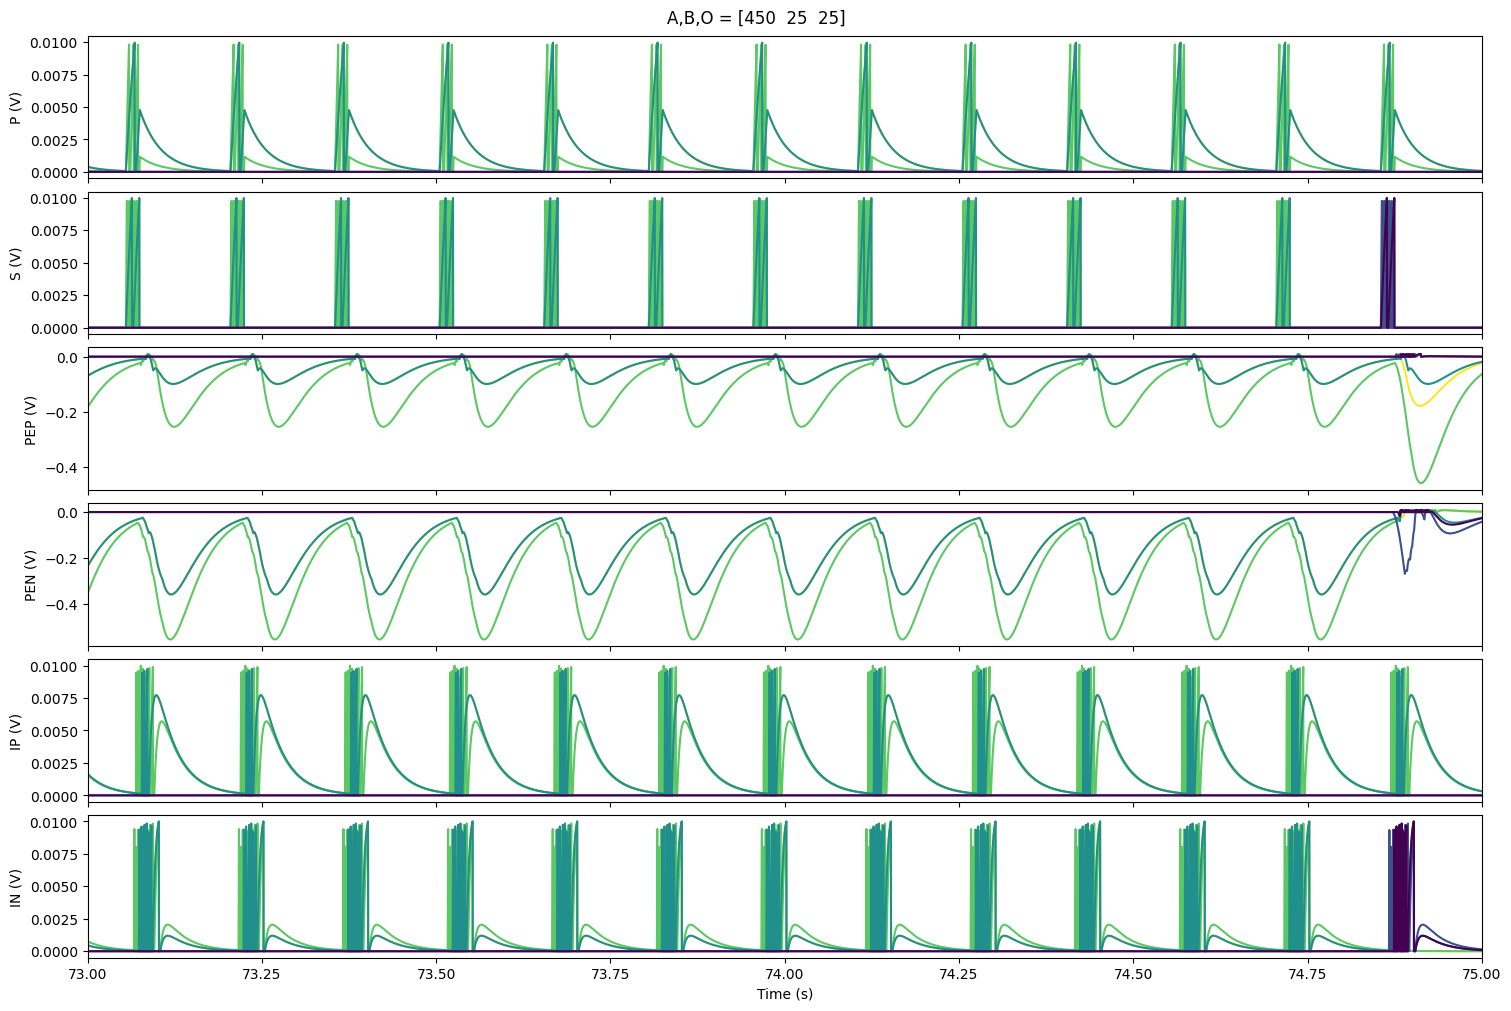

In [17]:
fig, axs = plt.subplots(6, figsize=(15,10), sharex=True, layout='constrained')
plt.suptitle(f'A,B,O = {occurrences}')
for ax, (label, monitor) in zip(axs, states.items()):
    plot_trace(ax, monitor, 'v')
    ax.set_ylabel(f'{label} (V)')
ax.set_xlim(runtime-2*second, runtime)
ax.set_xlabel('Time (s)');

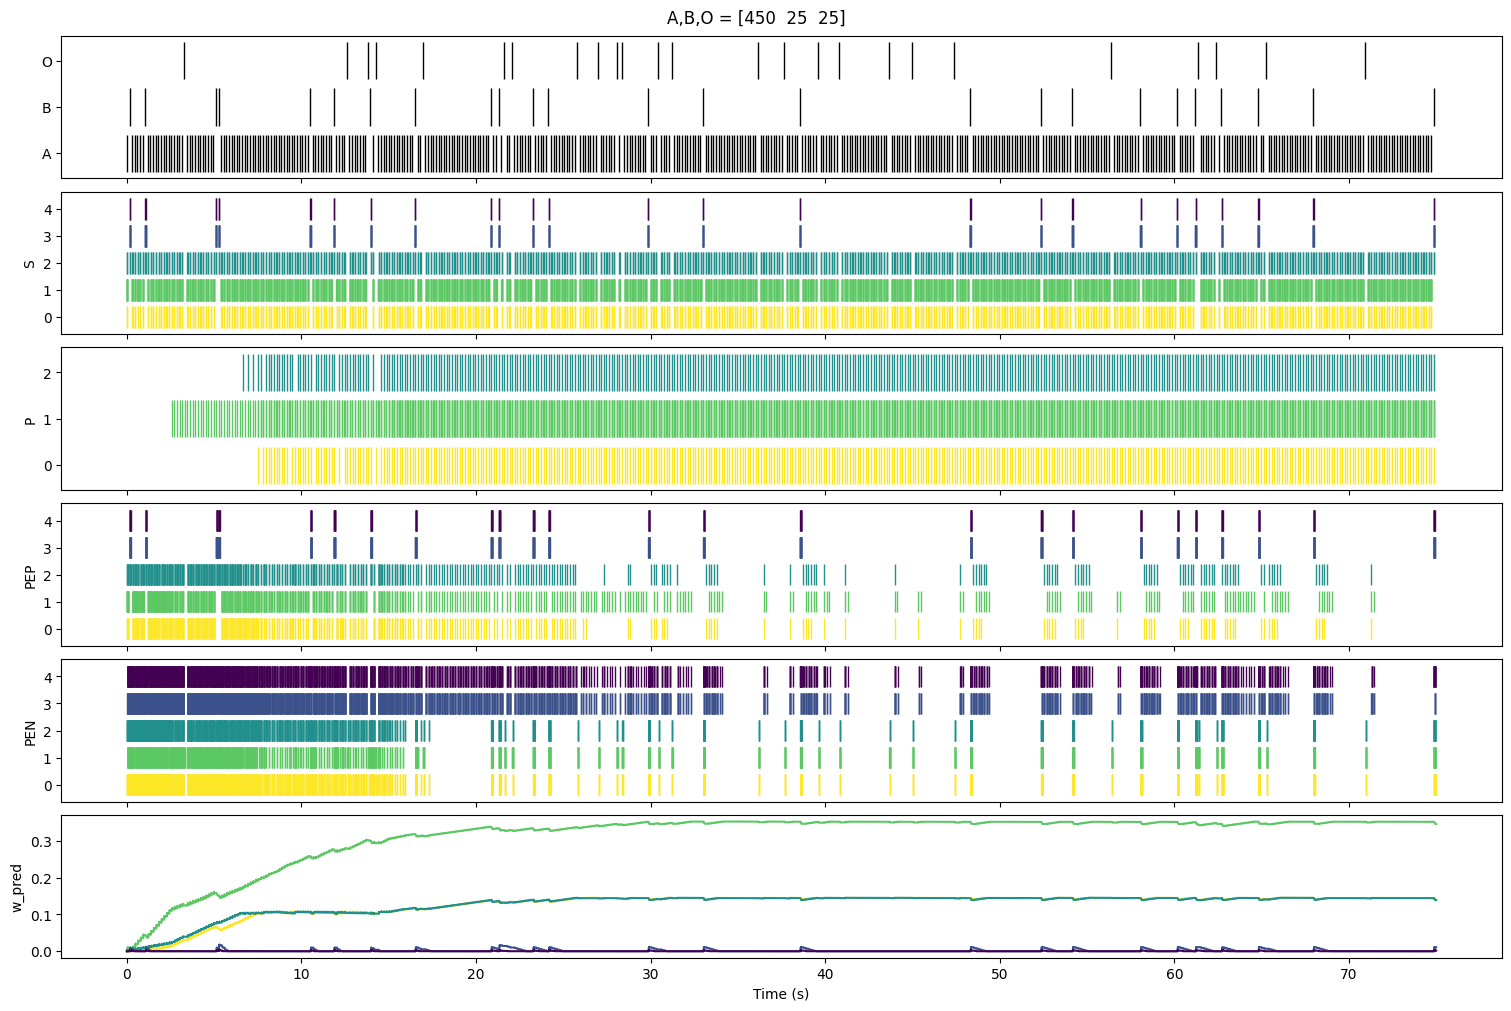

In [18]:
fig, axs = plt.subplots(6, figsize=(15,10), sharex=True, layout='constrained')
plt.suptitle(f'A,B,O = {occurrences}')

plot_stim_raster(axs[0], seq)

for group, ax in zip(['S', 'P', 'PEP', 'PEN'], axs[1:]):
    plot_raster(ax, spikes[group])
    ax.set_ylabel(group)

plot_trace(axs[5], states['P'], 'w_pred')
axs[5].set_ylabel('w_pred')
axs[5].set_xlabel('Time (s)');

In [19]:
def chunk_spike_train(spike_train, seq, dt=seq_dt, before=seq_dt, after=2*seq_dt):
    trains = {i: {} for i in np.unique(seq)}
    for trial, trial_stim in enumerate(seq):
        t0 = trial*dt
        mask = (spike_train > t0 - before) & (spike_train < t0 + after)
        trains[trial_stim][trial] = spike_train[mask] - t0
    return dict(trains=trains, dt=dt, before=before, after=after)

In [20]:
trains = chunk_spike_train(spikes['PEN'].spike_trains()[1], seq)

In [21]:
def plot_rates(ax, chunked_train, bins=50, ignore_first_trials=100):
    for i, trains in chunked_train['trains'].items():
        spikes = [v for t,v in trains.items() if t >= ignore_first_trials]
        counts, edges = np.histogram(np.concatenate(spikes), range=(-chunked_train['before']/second, chunked_train['after']/second), bins=bins)
        rates = counts / (edges[1]-edges[0]) / len(spikes)
        ax.plot(edges[:-1] + np.diff(edges)/2, rates, label=stim_labels[i])
    for x in (0, chunked_train['dt']/second):
        ax.axvline(x, color='r', ls='--', alpha=.2)
    ax.set_xlim(-chunked_train['before']/second, chunked_train['after']/second)
    ax.legend()
    ax.set_ylabel('Spike rate ($s^{-1}$)')
    ax.set_xlabel('Time ($s$)')

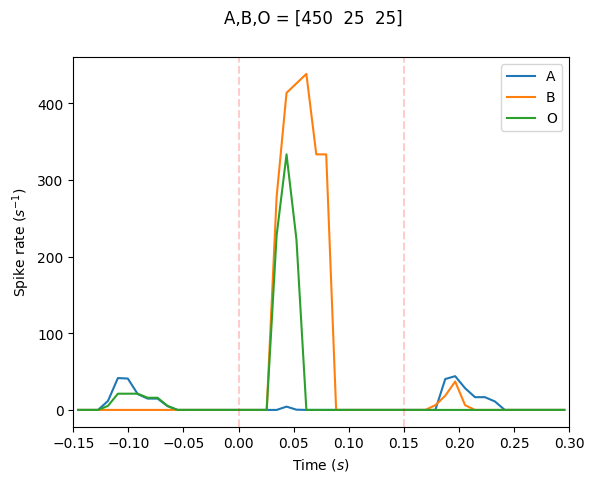

In [22]:
fig, ax = plt.subplots()
plt.suptitle(f'A,B,O = {occurrences}')
plot_rates(ax, trains)

In [23]:
def plot_trial_raster(axs, chunked_train):
    for i, trains in chunked_train['trains'].items():
        ax = axs[i]
        for trial, train in trains.items():
            ax.vlines(train, trial-.5, trial+.5, colors='k')
        for x in (0, chunked_train['dt']/second):
            ax.axvline(x, color='r', ls='--', alpha=.2)
        ax.set_xlim(-chunked_train['before'], chunked_train['after'])
        ax.set_ylabel('Trial')

Text(75. ms, 250.0, 'Omi of A')

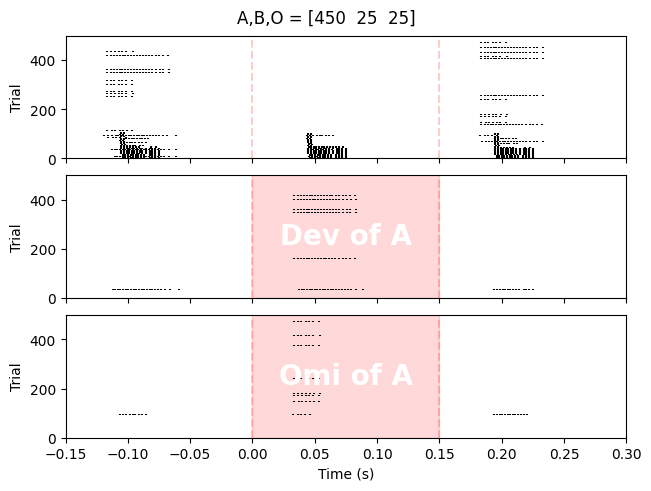

In [24]:
fig, axs = plt.subplots(3, sharex=True, sharey=True, layout='constrained')
plt.suptitle(f'A,B,O = {occurrences}')
plot_trial_raster(axs, trains)
axs[-1].set_ylim(0, n_trials)
axs[-1].set_xlabel('Time (s)')

axs[1].axvspan(0, seq_dt, color='r', alpha=.15)
axs[1].text(seq_dt/2, n_trials/2, 'Dev of A', color='white', fontweight='bold', fontsize=20, ha='center', va='center')

axs[2].axvspan(0, seq_dt, color='r', alpha=.15)
axs[2].text(seq_dt/2, n_trials/2, 'Omi of A', color='white', fontweight='bold', fontsize=20, ha='center', va='center')

In [25]:
stream_indices = [1, 3]
occurrences = np.asarray([5, 90, 5])*5
n_trials = sum(occurrences)
print(f'n_trials = {n_trials}')

runtime = sum(stim_timing)*stim_dt * n_trials
Pred = TimedArray(np.tile([1]*stim_timing[0] + [0]*stim_timing[1], n_trials) * input_strength, dt=stim_dt)

seq, stim_inputs = get_oddball_inputs(occurrences, stream_indices)
Stim = TimedArray(stim_inputs * input_strength, dt=stim_dt)

n_trials = 500


In [26]:
Net.restore()
Net.run(runtime)

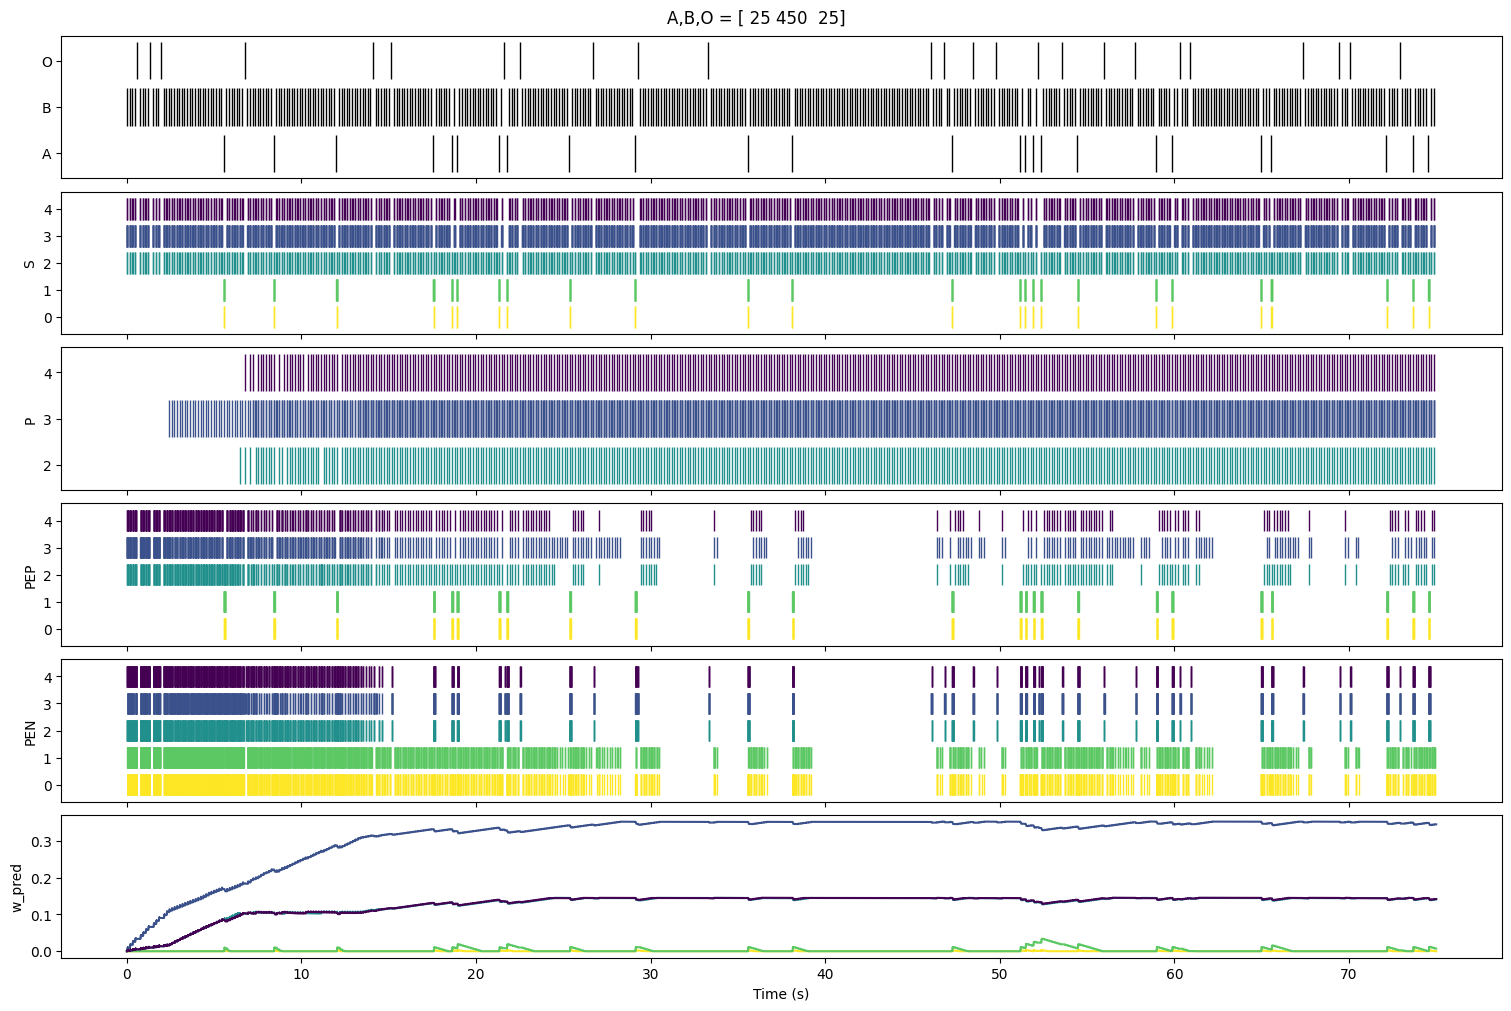

In [27]:
fig, axs = plt.subplots(6, figsize=(15,10), sharex=True, layout='constrained')
plt.suptitle(f'A,B,O = {occurrences}')

plot_stim_raster(axs[0], seq)

for group, ax in zip(['S', 'P', 'PEP', 'PEN'], axs[1:]):
    plot_raster(ax, spikes[group])
    ax.set_ylabel(group)

plot_trace(axs[5], states['P'], 'w_pred')
axs[5].set_ylabel('w_pred')
axs[5].set_xlabel('Time (s)');

In [28]:
trains = chunk_spike_train(spikes['PEN'].spike_trains()[1], seq)

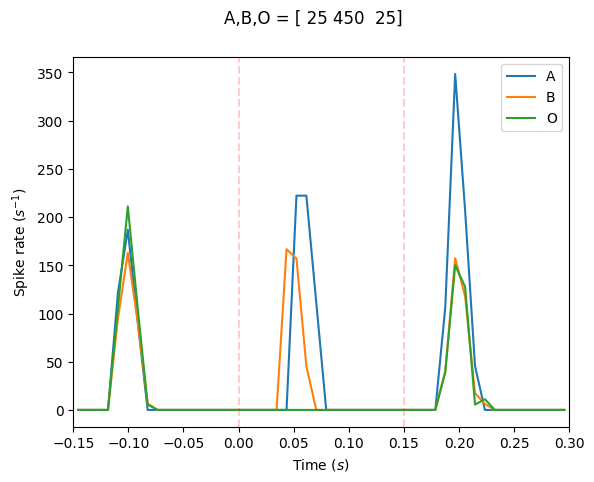

In [29]:
fig, ax = plt.subplots()
plt.suptitle(f'A,B,O = {occurrences}')
plot_rates(ax, trains)

Text(75. ms, 250.0, 'Dev of B')

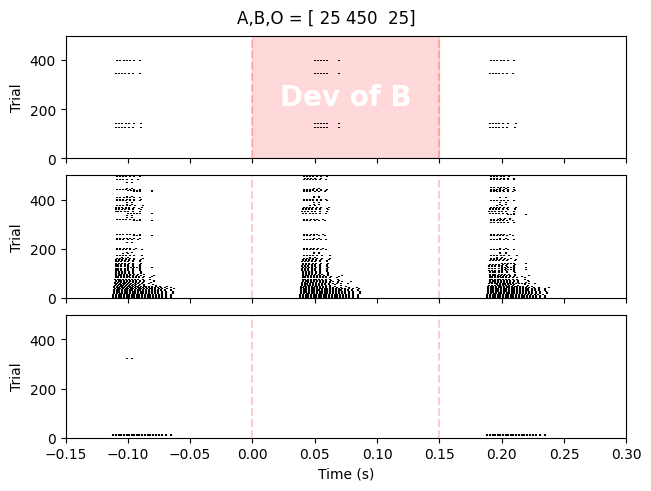

In [30]:
fig, axs = plt.subplots(3, sharex=True, sharey=True, layout='constrained')
plt.suptitle(f'A,B,O = {occurrences}')
plot_trial_raster(axs, trains)
axs[-1].set_ylim(0, n_trials)
axs[-1].set_xlabel('Time (s)')

axs[0].axvspan(0, seq_dt, color='r', alpha=.15)
axs[0].text(seq_dt/2, n_trials/2, 'Dev of B', color='white', fontweight='bold', fontsize=20, ha='center', va='center')

In [31]:
def sweep_p_A(all_p_A, network, states):
    stream_indices = [1, 3]
    all_w_pred = []
    for p_A in all_p_A:
        occurrences = np.asarray([p_A, 95-p_A, 5])*5
        n_trials = sum(occurrences)
        runtime = sum(stim_timing)*stim_dt * n_trials
        Pred = TimedArray(np.tile([1]*stim_timing[0] + [0]*stim_timing[1], n_trials) * input_strength, dt=stim_dt)

        seq, stim_inputs = get_oddball_inputs(occurrences, stream_indices)
        Stim = TimedArray(stim_inputs * input_strength, dt=stim_dt)

        print(f'Running for p(A) = {p_A}%...')
        network.restore()
        network.run(runtime)

        all_w_pred.append(states['P'].w_pred[stream_indices[0]])
    return np.asarray(all_w_pred), seq, runtime

In [32]:
all_p_A = np.arange(5, 100, 5)  # (5, 10, ..., 95)
all_w_pred, seq, runtime = sweep_p_A(all_p_A, Net, states)

Running for p(A) = 5%...
Running for p(A) = 10%...
Running for p(A) = 15%...
Running for p(A) = 20%...
Running for p(A) = 25%...
Running for p(A) = 30%...
Running for p(A) = 35%...
Running for p(A) = 40%...
Running for p(A) = 45%...
Running for p(A) = 50%...
Running for p(A) = 55%...
Running for p(A) = 60%...
Running for p(A) = 65%...
Running for p(A) = 70%...
Running for p(A) = 75%...
Running for p(A) = 80%...
Running for p(A) = 85%...
Running for p(A) = 90%...
Running for p(A) = 95%...


Text(0.5, 0, 'Time (s)')

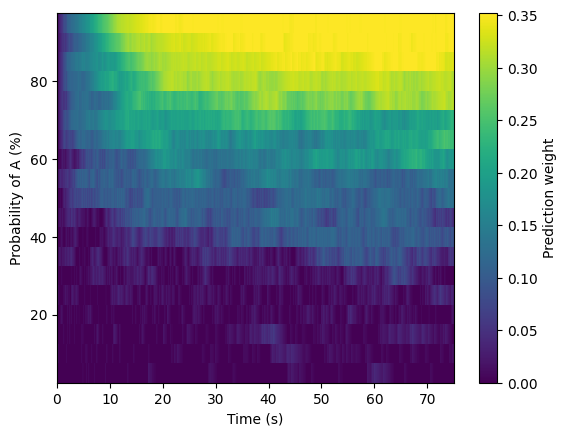

In [33]:
m = plt.pcolormesh(np.linspace(0, runtime, all_w_pred.shape[1]), all_p_A, all_w_pred)
plt.colorbar(m, label='Prediction weight')
plt.ylabel('Probability of A (%)')
plt.xlabel('Time (s)')

In [34]:
Net_nolaterals = Network()
neurons_nolaterals, states_nolaterals, spikes_nolaterals = make_neurons(Net_nolaterals)
synapses_nolaterals = make_column_synapses(Net_nolaterals, neurons_nolaterals)
Net_nolaterals.store()

In [35]:
all_p_A = np.arange(5, 100, 5)  # (5, 10, ..., 95)
all_w_pred_nolaterals, seq_nolaterals, runtime = sweep_p_A(all_p_A, Net_nolaterals, states_nolaterals)

Running for p(A) = 5%...
Running for p(A) = 10%...
Running for p(A) = 15%...
Running for p(A) = 20%...
Running for p(A) = 25%...
Running for p(A) = 30%...
Running for p(A) = 35%...
Running for p(A) = 40%...
Running for p(A) = 45%...
Running for p(A) = 50%...
Running for p(A) = 55%...
Running for p(A) = 60%...
Running for p(A) = 65%...
Running for p(A) = 70%...
Running for p(A) = 75%...
Running for p(A) = 80%...
Running for p(A) = 85%...
Running for p(A) = 90%...
Running for p(A) = 95%...


Text(0.5, 0, 'Time (s)')

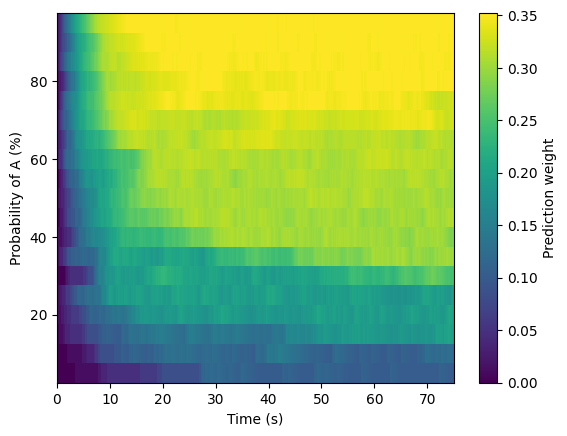

In [36]:
m = plt.pcolormesh(np.linspace(0, runtime, all_w_pred_nolaterals.shape[1]), all_p_A, all_w_pred_nolaterals)
plt.colorbar(m, label='Prediction weight')
plt.ylabel('Probability of A (%)')
plt.xlabel('Time (s)')

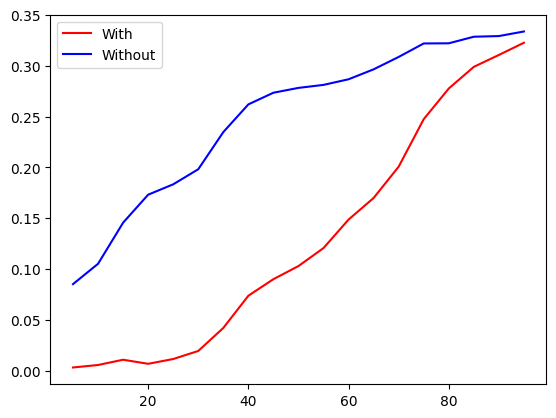

In [37]:
plt.plot(all_p_A, all_w_pred.mean(1), 'r', label='With')
plt.plot(all_p_A, all_w_pred_nolaterals.mean(1), 'b', label='Without')
plt.legend()